In [1]:
#import required modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
#get mitochondrial genome informations
mtdnas=pd.read_csv('../../data/organelles.csv',index_col=0)
mtdnas=mtdnas.loc[['Mus musculus LP/J','Mus musculus C3H/HeJ','Mus musculus BALB/cJ','Mus musculus A/J',
                  'Mus musculus castaneus CAST/EiJ','Mus musculus NOD/ShiLtJ','Mus musculus domesticus AKR/J',
                  'Mus musculus domesticus WSB/EiJ','Mus musculus DBA/2J','Mus musculus 129S1/SvImJ',
                  'Mus musculus musculus PWK/PhJ','Mus musculus CBA/J','Mus musculus NZO/HiLtJ',
                  'Mus musculus FVB/NJ','Mus musculus C57BL/6NJ','Mus spretus SPRET/EiJ']]
mtdnas=mtdnas[~mtdnas.index.duplicated(keep='first')]
mtdnas.index=pd.Series(mtdnas.index.values).apply(lambda name:name.split(' ')[-1].lower().replace('/',''))

In [3]:
#load numts csv files
def read_dfs(filename):
    try:
        df=pd.read_csv(f'/Volumes/motilin/balint/numt/mice_strains_numt/csvs/{filename}')
        return df
    except:
        return np.nan
    
numts=pd.Series(os.listdir('/Volumes/motilin/balint/numt/mice_strains_numt/csvs/')).apply(read_dfs)
numts.index=pd.Series(os.listdir('/Volumes/motilin/balint/numt/mice_strains_numt/csvs/')).apply(lambda filename:filename[:-10])
numts=numts.dropna()
numts=numts.drop('Mus_musculus')
numts

Mus_musculus_lpj                score      eg2_value        e_value g_id ...
Mus_musculus_c3hhej             score      eg2_value        e_value g_id ...
Mus_musculus_balbcj             score      eg2_value        e_value g_id ...
Mus_musculus_aj                 score  eg2_value   e_value g_id   g_start...
Mus_musculus_casteij            score      eg2_value        e_value g_id ...
Mus_musculus_nodshiltj          score      eg2_value        e_value g_id ...
Mus_musculus_akrj               score      eg2_value        e_value g_id ...
Mus_musculus_wsbeij             score      eg2_value        e_value g_id ...
Mus_musculus_dba2j              score      eg2_value        e_value g_id ...
Mus_musculus_129s1svimj         score      eg2_value        e_value g_id ...
Mus_musculus_pwkphj             score      eg2_value        e_value g_id ...
Mus_musculus_cbaj               score      eg2_value        e_value g_id ...
Mus_musculus_fvbnj              score      eg2_value        e_value g_id ...

In [4]:
#set order
dfs=numts.loc[['Mus_musculus_casteij','Mus_musculus_spreteij', 'Mus_musculus_pwkphj','Mus_musculus_wsbeij',
         'Mus_musculus_lpj', 'Mus_musculus_c3hhej', 'Mus_musculus_balbcj',
       'Mus_musculus_aj', 
       'Mus_musculus_nodshiltj', 'Mus_musculus_akrj',
        'Mus_musculus_dba2j',
       'Mus_musculus_129s1svimj', 
       'Mus_musculus_cbaj', 'Mus_musculus_nzohiltj', 'Mus_musculus_fvbnj',
       'Mus_musculus_c57bl6nj']]
dfs

Mus_musculus_casteij            score      eg2_value        e_value g_id ...
Mus_musculus_spreteij           score      eg2_value        e_value g_id ...
Mus_musculus_pwkphj             score      eg2_value        e_value g_id ...
Mus_musculus_wsbeij             score      eg2_value        e_value g_id ...
Mus_musculus_lpj                score      eg2_value        e_value g_id ...
Mus_musculus_c3hhej             score      eg2_value        e_value g_id ...
Mus_musculus_balbcj             score      eg2_value        e_value g_id ...
Mus_musculus_aj                 score  eg2_value   e_value g_id   g_start...
Mus_musculus_nodshiltj          score      eg2_value        e_value g_id ...
Mus_musculus_akrj               score      eg2_value        e_value g_id ...
Mus_musculus_dba2j              score      eg2_value        e_value g_id ...
Mus_musculus_129s1svimj         score      eg2_value        e_value g_id ...
Mus_musculus_cbaj               score      eg2_value        e_value g_id ...

In [5]:
#sliding window
#sliding window
def sliding_window(numts_df,step_size):
    global row_tracker
    global column_tracker
    global indexer
    indexer+=1
    mt_size=int(mtdnas.loc[dfs.index.values[indexer].split('_')[-1]]['Size(Mb)']*1000000)
    window_size=int(mt_size/10)
    numts_df=numts_df.sort_values(by='mt_start')
    numts_df=numts_df.loc[numts_df['mt_start']<mt_size-1]
    ranges=numts_df.apply(lambda row: list(np.arange(row['mt_start'],(row['mt_start']+row['mt_length']))),axis=1)
    merged=[]
    for array in ranges:
        if type(array)==list:
            merged+=array
    merged=pd.Series(merged)
    bp_counts=merged.value_counts().sort_index(ascending=True)
    bp_counts=pd.Series(np.zeros(mt_size)).combine(bp_counts,max,fill_value=0)
    summation=sum(bp_counts)
    bp_involved=[]
    for i in np.arange(0,len(bp_counts),step_size):
        bp_involved.append((sum(bp_counts[i:i+window_size])/summation)*100)
    return bp_involved

indexer=-1
bps_involved=dfs.apply(sliding_window, args=(1,))

In [6]:
bps_involved=bps_involved.apply(lambda row:pd.Series(row))
bps_involved=bps_involved.dropna(axis=1).T
bps_involved.columns=pd.Series(bps_involved.columns).apply(lambda strain:strain.split('_')[-1])

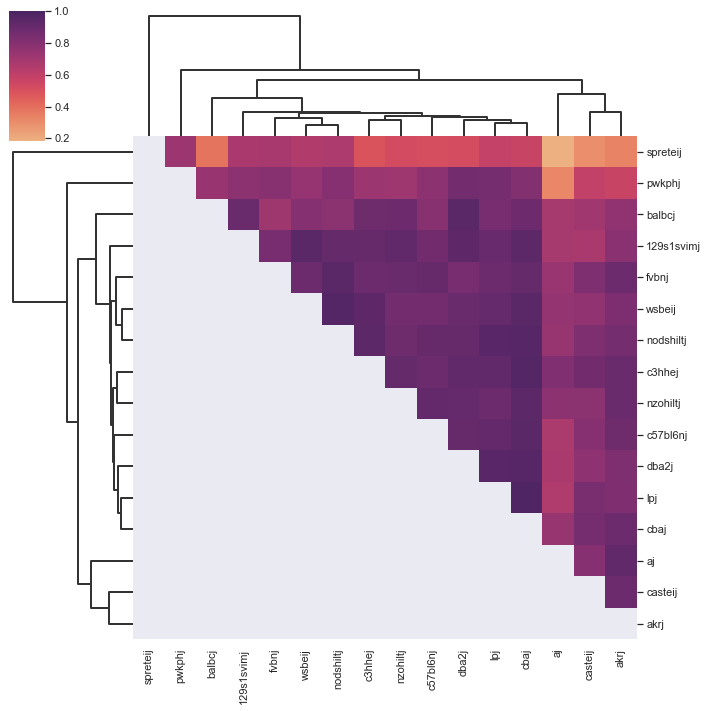

In [10]:
sns.set(font_scale=1)
heatmap=sns.clustermap(bps_involved.corr(),cmap='flare',
                  tree_kws=dict(linewidths=2))
fil=np.tril(np.ones_like(bps_involved.corr()))
values=heatmap.ax_heatmap.collections[0].get_array().reshape(bps_involved.corr().shape)
new_values=np.ma.array(values, mask=fil)
heatmap.ax_heatmap.collections[0].set_array(new_values)
heatmap.savefig('../../results/numts_bp_corr.png',dpi=200)